# 09. 객체탐지 실습
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow

## 과제: 마스크 탐지
<p align='center'>
<img src=https://github.com/kairess/mask-detection/raw/master/imgs/result.png   width=400>
</p>


---
### 모델1: 탐지
---

* 마스크탐지: 
  1. 이미지를 모델에 넣으면
  1. 이미지에서 얼굴 영역만 찾고
  1. 크롭된 영역만 분류 모델에 넘기기 


In [2]:
! pip install face_recognition

     |████████████████████████████████| 100.1 MB 19 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=3e733b9f58e45ca2f3ec02c4253518bb7f8cdfcca9782e5715efb4f6f4377aeb
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [3]:
import face_recognition as fr

In [4]:
! git clone https://github.com/yebiny/Face-detection-for-DSM.git

Cloning into 'Face-detection-for-DSM'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 52 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (52/52), done.
Checking out files: 100% (25/25), done.


In [5]:
model_dir =  '/content/Face-detection-for-DSM/models'
facenet = cv2.dnn.readNet(model_dir+'/deploy.prototxt',
                          model_dir+'/res10_300x300_ssd_iter_140000.caffemodel')
                          


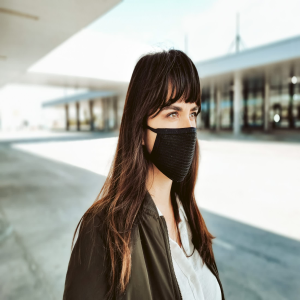

In [6]:
img_path ='mask1.jpg'
img =cv2.imread(img_path)
img = cv2.resize(img,dsize=(300,300),interpolation = cv2.INTER_AREA)
cv2_imshow(img)
h, w ,_ = img.shape

0.0 149 77 201 166


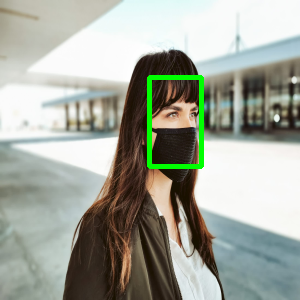

In [7]:
img_blob = cv2.dnn.blobFromImage(img,scalefactor=1.0 ,size =(300,300))
facenet.setInput(img_blob)
preds = facenet.forward()[0][0]

thres =0.5
for i in range(len(preds)):
  conf = preds[i,2]
  if conf <thres:
    continue
  x1= int(preds[i,3]*h)
  y1= int(preds[i,4]*w)
  x2= int(preds[i,5]*h)
  y2= int(preds[i,6]*w)

print(conf, x1,y1,x2,y2)
cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
cv2_imshow(img)

---
### 모델2: 분류
---

1. 탐지를 통해 얼굴사진이 들어오면
1. 분류모델을 통해 마스크/하품  판단하기

분류모델은 만들어지지 않았기 때문에 직접 만들도록 합니다.

#### **데이터준비**


* 마스크 데이터 로드

```
! git clone https://github.com/prajnasb/observations.git
```

* 위치: `observations/experiements/data/`

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [9]:
! git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 15.08 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (3045/3045), done.


In [10]:
data_dir = 'observations/experiements/data/'
for class_name in ['with_mask',  'without_mask']:
  #각 폴더의 파일들을 확인
  f_list=glob.glob('%s/%s/*jpg'%('observations/experiements/data/',class_name))
  print(class_name)
  print(len(f_list))

with_mask
690
without_mask
686


In [11]:
from tensorflow.keras import preprocessing

IMG_SIZE =160
BATCH_SIZE= 16
N_CLASS = 1

In [12]:
print(data_dir)

observations/experiements/data/


In [13]:
train_ds  = preprocessing.image_dataset_from_directory(data_dir,#데이터가 위치한 경로
                                                       subset="training",
                                                       validation_split = 0.2,
                                                       image_size = (IMG_SIZE,IMG_SIZE),
                                                       batch_size = BATCH_SIZE,
                                                       seed=1)
valid_ds  = preprocessing.image_dataset_from_directory(data_dir,#데이터가 위치한 경로
                                                       subset="validation",
                                                       validation_split = 0.2,
                                                       image_size = (IMG_SIZE,IMG_SIZE),
                                                       batch_size = BATCH_SIZE,
                                                       seed=1)

Found 1376 files belonging to 2 classes.
Using 1101 files for training.
Found 1376 files belonging to 2 classes.
Using 275 files for validation.


In [14]:
from tensorflow.keras import layers, models, losses, optimizers

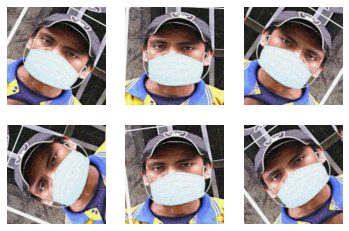

In [15]:
aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
for imgs, labels, in train_ds.take(1):
  img = imgs[0]
  for i in range(6):
    plt.subplot(2,3,i+1)
    aug_img = aug(img)
    plt.imshow(aug_img/255)
    plt.axis('off')
plt.show()

#### **모델 학습**

In [16]:
from tensorflow.keras import applications
base_model = applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                      include_top=False,
                                      weights='imagenet')
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [17]:
base_model.trainable = False

In [18]:
x = layers.Input(shape=(160,160,3))
z = aug(x)                                    
z = applications.mobilenet_v2.preprocess_input(z) 
z = base_model(z,training= False)
z = layers.GlobalAveragePooling2D()(z) 
z = layers.Dropout(0.2)(z)
y = layers.Dense(N_CLASS,activation='sigmoid')(z)
transfer = models.Model(x,y)
transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (160, 160, 3)             0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [19]:
from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        factor=0.2,
                                        patience=2,
                                        min_lr = 0.000001)
ckp = callbacks.ModelCheckpoint(filepath='transfer.h5',save_best_only=True)

In [20]:
transfer.compile(loss = losses.BinaryCrossentropy(),
                 optimizer =optimizers.Adam(learning_rate=0.0001),
                 metrics = ['accuracy'])

In [21]:
history_transfer  = transfer.fit(train_ds, 
                                 validation_data=valid_ds,
                                 epochs =20,
                                 callbacks = [reduce_lr,ckp])

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.5550WARNING:tensorflow:Model was constructed with shape (160, 160, 3) for input KerasTensor(type_spec=TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 160, 160, 3).


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


69/69 [==============================] - 20s 89ms/step - loss: 0.7475 - accuracy: 0.5550 - val_loss: 0.4935 - val_accuracy: 0.8145 - lr: 1.0000e-04
Epoch 2/20
69/69 [==============================] - 5s 63ms/step - loss: 0.5370 - accuracy: 0.7257 - val_loss: 0.3465 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 3/20
69/69 [==============================] - 5s 65ms/step - loss: 0.4297 - accuracy: 0.8174 - val_loss: 0.2580 - val_accuracy: 0.9636 - lr: 1.0000e-04
Epoch 4/20
69/69 [==============================] - 5s 65ms/step - loss: 0.3331 - accuracy: 0.8828 - val_loss: 0.2044 - val_accuracy: 0.9745 - lr: 1.0000e-04
Epoch 5/20
69/69 [==============================] - 5s 64ms/step - loss: 0.2741 - accuracy: 0.9183 - val_loss: 0.1675 - val_accuracy: 0.9782 - lr: 1.0000e-04
Epoch 6/20
69/69 [==============================] - 5s 65ms/step - loss: 0.2511 - accuracy: 0.9192 - val_loss: 0.1416 - val_accuracy: 0.9782 - lr: 1.0000e-04
Epoch 7/20
69/69 [==============================] - 5s 66ms/st

In [22]:
def plot_lcurve(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  plt.style.use('ggplot')
  plt.figure(figsize = (15,5))

  plt.subplot(1,2,1)
  plt.title('Accuracy')
  plt.plot(acc, marker='.', label = 'train')
  plt.plot(val_acc, marker='.' , label = 'valid')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title("loss")
  plt.plot(loss, marker='.' , label = 'train')
  plt.plot(val_loss, marker='.' ,label = 'valid')
  plt.legend()
  plt.show()

In [23]:
transfer.evaluate(valid_ds)

18/18 [==============================] - 1s 38ms/step - loss: 0.0425 - accuracy: 0.9964


[0.04245077446103096, 0.996363639831543]

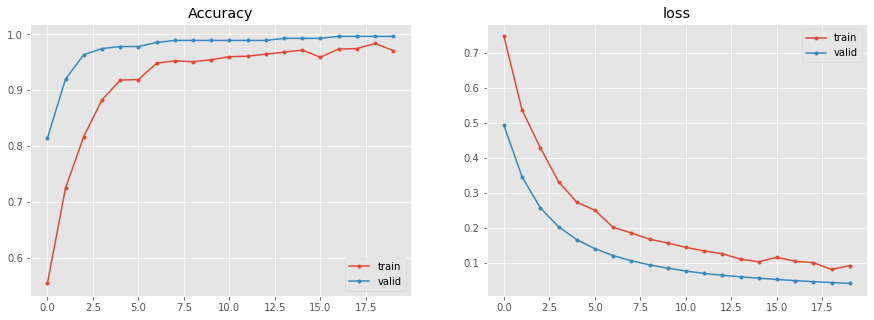

In [79]:
 plot_lcurve(history_transfer)

In [80]:
transfer.save('mask_classifier.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [26]:
mask_model = models.load_model('mask_classifier.h5')

(16, 1)
(16,)
[0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1]
[0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1]
(16,)


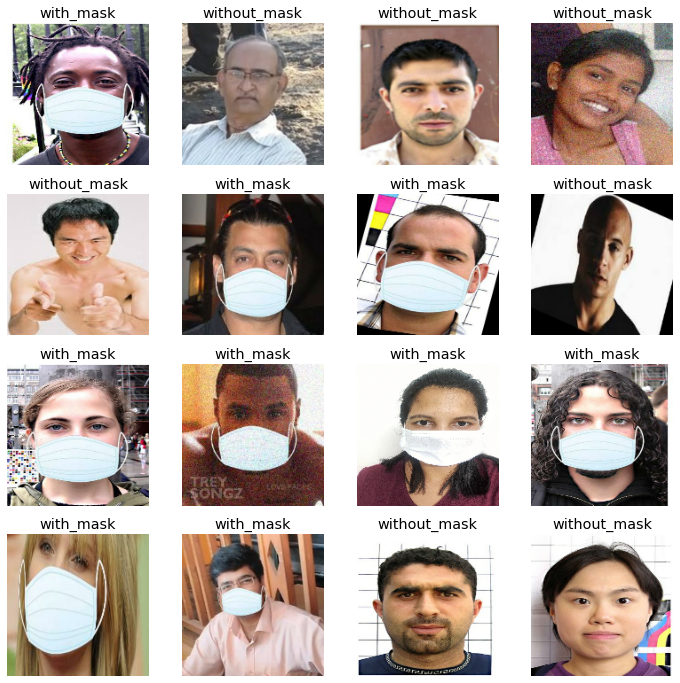

In [27]:
imgs, labels = valid_ds.as_numpy_iterator().next()
#print(img.shape,labels.shape)
preds = transfer.predict_on_batch(imgs)
print(preds.shape)
preds = np.array(np.round(preds),dtype='uint8').reshape(16,)
print(preds.shape)
print(preds)
print(labels)
print(labels.shape)
plt.figure(figsize=(12,12))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(imgs[i].astype("uint8"))
  plt.title(valid_ds.class_names[preds[i]])
  plt.axis('off')
plt.show()

<PIL.Image.Image image mode=RGB size=160x160 at 0x7F866A872F90>
[[1.]]


(-0.5, 159.5, 159.5, -0.5)

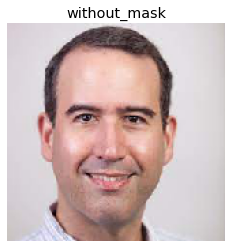

In [50]:
img_path = 'nomask.jpg'
img = plt.imread(img_path)
img = preprocessing.image.load_img(img_path,
                                   target_size=(IMG_SIZE,IMG_SIZE))
print(img)
img_arr = preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)   #(1,160,160,3)
pred = transfer.predict_on_batch(img_arr)
pred=  np.round(pred)
print(pred)

plt.title(train_ds.class_names[int(pred[0])])
plt.imshow(img)
plt.axis('off')


---
### 탐지 전체 플로우
---

이미지 -> ( **탐지모델** ) -> 얼굴 크롭된 이미지 -> ( **분류모델** ) -> visualization 된 이미지 

In [158]:
! git clone https://github.com/yebiny/Face-detection-for-DSM.git

fatal: destination path 'Face-detection-for-DSM' already exists and is not an empty directory.


In [170]:
facenet = cv2.dnn.readNet(model_dir+'/deploy.prototxt',
                          model_dir+'/res10_300x300_ssd_iter_140000.caffemodel')
                          
img_path = 'nomask.jpg'
img = cv2.imread(img_path)
img_h, img_w ,_ = img.shape
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
# construct a blob from the image
blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300),(104.0, 177.0, 123.0))
facenet.setInput(blob)
detections = facenet.forward()

faces=[]
for i in range(detections.shape[2]):
  conf = detections[0,0,i,2]
  if conf <0.5:
    continue
  x1 = int(detections[0,0,i,3]*img_w)
  y1 = int(detections[0,0,i,4]*img_h)
  x2 = int(detections[0,0,i,5]*img_w)
  y2 = int(detections[0,0,i,6]*img_h)

  face = img[y1:y2, x1:x2]
  faces.append(face)

[INFO] computing face detections...


(1, 160, 160, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.9094906]]
No Mask


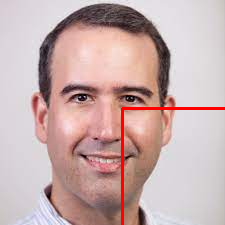

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 160, 160, 3)
[[0.88275695]]
No Mask


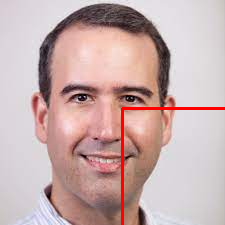

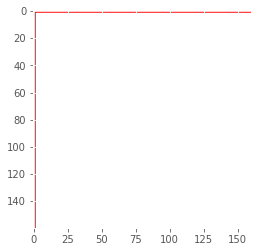

In [171]:
from tensorflow.keras.preprocessing.image import img_to_array
for face in faces:
  face = cv2.resize(face,(IMG_SIZE,IMG_SIZE))
  face = img_to_array(face)
  face = np.expand_dims(face,axis=0)
  print(face.shape)
  plt.imshow(cv2.cvtColor(face[0],cv2.COLOR_BGR2RGB))
  # predict
  mask = transfer.predict_on_batch(face)
  print(mask)

  # visualize
  label = "Mask" if mask < 1-mask else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
  print(label)
  cv2.putText(img, label, (x1, y2 - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
  cv2_imshow(img)

[[0.02010778]]
Mask


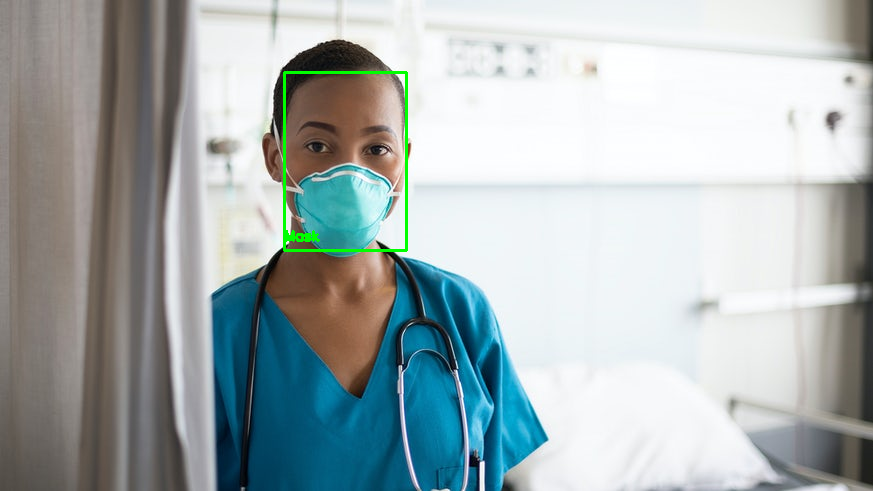

In [169]:
# predict
mask = transfer.predict_on_batch(face)
print(mask)

# visualize
label = "Mask" if mask < 1-mask else "No Mask"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
print(label)
cv2.putText(img, label, (x1, y2 - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
cv2_imshow(img)